# Imports and configuration

In [1]:
import pandas as pd
import numpy as np
import cvxpy as cp
import gurobipy as gp

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from tqdm import tqdm

# internal utils
from utils import *

In [2]:
# autoreload modified libraries
%load_ext autoreload
%autoreload 2

# Retrieve data

In [3]:
# PUT YOUR OWN mu.pkl and L.pkl inside the resources/ directory
RESOURCES_DIR = os.path.join(os.getcwd(), "resources")
mu_dict = pd.read_pickle(f"{RESOURCES_DIR}/mu.pkl")
beta_dict = pd.read_pickle(f"{RESOURCES_DIR}/L.pkl")
len(beta_dict), len(mu_dict)

(79, 79)

In [4]:
n_samples, n_assets, n_factors = len(beta_dict), beta_dict[0].shape[0], beta_dict[0].shape[1]
n_samples, n_assets, n_factors

(79, 5058, 42)

In [5]:
# noise variance ~ var(alpha)
mu_df = pd.DataFrame(mu_dict)
Psi = mu_df.var(axis=1).values
Psi

array([0.01621194, 0.05394101, 0.11801196, ..., 0.03430027, 0.01016757,
       0.01026194])

# Benchmarking

## Setting
For this experiment, our data consists of factor loadings (or betas) $L$ where we model the covariance matrix as
$$\hat{G} = \Psi + \mathbf{L} \Sigma_f \mathbf{L}^T$$
where $\Psi$ is noise covariance matrix, which we assume is a diagonal matrix, and $\Sigma_f$ is a covariance matrix of factors. For the sake of the experiment, we will assume $\Sigma_f = \mathbf{I}$ and $\Psi_{ii} \approx Var(\text{asset i return})$.

We will compare the performance of ReHLine-based portfolio optimization method against competing methods like MOSEK and GUROBI in solving the Mean-Variance model with transaction costs:

$$\min_{\mathbf{w} \in \R^n} \frac{C}{2} \mathbf{w}^T \hat{\mathbf{G}} \mathbf{w} - \mu^T \mathbf{w} + \sum_{i=1}^n \phi_i(w_i)$$

where $\phi_i$ is a piece-wise linear transaction cost function. Methods will be compared for different complexities (i.e. #linear pieces) of $\phi_i$.

## 1. Simulated data

Let's test the experiment with simulated data first. We will assume that $\mu \sim Unif(-0.5, 0.5)$
$\mathbf{L}_{ij} \sim Unif(-0.5, 0.5)$, $\Sigma_f = \mathbf{I}$, and $\Psi = \lambda \mathbf{I}$, where
we will control $\lambda > 0$.

In [10]:
# testing ReHLine-PO with FactorModel
from rehline_po import FactorModel

n_assets, n_factors = 1000, 20
lb, ub = -1.0, 1.0
buy_cost, sell_cost = 0.01*np.ones(n_assets), 0.02*np.ones(n_assets)
risk_aversion = 2.0

max_iter = 1000
tol = 1e-4
verbose = 0
trace_freq = 10

L = np.random.uniform(size=(n_assets, n_factors))
lam = 0.2
Psi = lam * np.ones(n_assets)
mu = random_mu(n_assets)
cov_fm = FactorModel(L, Psi, np.eye(n_factors))
cov = cov_fm.get_cov()

A = np.r_[
    np.c_[np.ones(n_assets), np.ones(n_assets)*-1.0].T, 
    np.eye(n_assets),
    -np.eye(n_assets)]
b = np.r_[-1.0, 1.0, -np.ones(n_assets)*lb, np.ones(n_assets)*ub]

pf1 = MeanVariance(mu=mu, cov=cov_fm, A=A, b=b, buy_cost=buy_cost, sell_cost=sell_cost)
weights_fm = pf1.max_quad_util_portf(tol=tol, risk_aversion=risk_aversion, 
                    max_iter=max_iter, verbose=verbose, trace_freq=trace_freq)
# print("Factor Model ReHLine-PO:", weights_fm)

weights_mosek = max_quad_util_portf_mosek(n_assets, mu, cov, risk_aversion, 
                                            buy_cost, sell_cost, lb, ub, tol, debug=False)
# print("MOSEK:", weights_mosek)

print("l2_dist(mosek, factor_model)", LA.norm(weights_fm - weights_mosek))

l2_dist(mosek, factor_model) 0.0006052914378282741


Note that with Factor modelling covariance operations like taking its inverse, or multiplying it (or its inverse) by some vector takes $O(NF^2)$ time instead of $O(N^3)$ which is supposed to give a significant speed-up in performance for the augmented ReHLine algorithm.

In [11]:
F = 40

numpy_time, factor_model_time = [], []
for i in tqdm(range(6, 14)):
    N = 2**i
    L = np.random.uniform(size=(N, F))
    lam = 0.2
    Psi = lam * np.ones(N)
    mu = random_mu(N)
    x = np.random.normal(size=N)
    start = time.time()
    cov_fm = FactorModel(L, Psi, np.eye(F))
    cov_fm.invcov_rightmult(x)
    end = time.time()
    factor_model_time.append(end - start)
    cov = cov_fm.get_cov()
    start = time.time()
    covinv = LA.inv(cov)
    x @ covinv
    end = time.time()
    numpy_time.append(end - start)

  0%|                                                     | 0/8 [00:00<?, ?it/s]

 75%|█████████████████████████████████▊           | 6/8 [01:04<00:21, 10.68s/it]


KeyboardInterrupt: 

: 

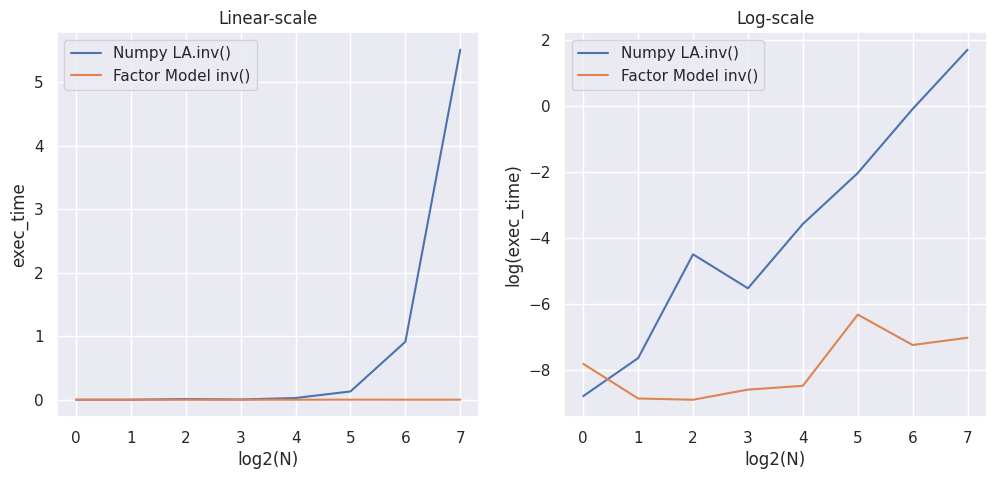

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(numpy_time, label="Numpy LA.inv()")
ax[0].plot(factor_model_time, label="Factor Model inv()")
ax[0].legend()
ax[0].set_title("Linear-scale")
ax[0].set_xlabel("log2(N)")
ax[0].set_ylabel("exec_time")

ax[1].plot(np.log(numpy_time), label="Numpy LA.inv()")
ax[1].plot(np.log(factor_model_time), label="Factor Model inv()")
ax[1].legend()
ax[1].set_xlabel("log2(N)")
ax[1].set_ylabel("log(exec_time)")
ax[1].set_title("Log-scale")
plt.show()

In [ ]:
risk_aversion = 2.0
vp, vm = 0.01, 0.02
lb, ub = -1.0, 1.0
n_factors = 40
lam = 0.2

tol = 1e-4
max_iter = 1000
verbose = 0
trace_freq = 10

Ns = [2**i for i in range(6, 14)]
n_pts = len(Ns)
n_tries = 10

mean_exec_times_mosek = np.zeros(n_pts)
mean_exec_times_reh_lt = np.zeros(n_pts)
mean_exec_times_reh_fm = np.zeros(n_pts)

std_exec_times_mosek = np.zeros(n_pts)
std_exec_times_reh_lt = np.zeros(n_pts)
std_exec_times_reh_fm = np.zeros(n_pts)

for i in tqdm(range(n_pts)):
    exec_times_mosek, exec_times_reh_fm, exec_times_reh_lt = [], [], []
    for _ in range(n_tries):
        n_assets = Ns[i]
        buy_cost, sell_cost = vp*np.ones(n_assets), vm*np.ones(n_assets)
        L = np.random.uniform(size=(n_assets, n_factors))
        Psi = lam * np.ones(n_assets)
        mu = random_mu(n_assets)

        # ReHLine-PO with linear transformation
        start = time.time()
        cov = L @ L.T + np.diag(Psi)
        weights_reh_lt, _ = max_quad_util_portf_rehline(n_assets, mu, cov, risk_aversion, 
                                                        buy_cost, sell_cost, lb, ub, 
                                                        max_iter, tol, verbose, trace_freq)
        end = time.time()
        exec_times_reh_lt.append(end - start)
        
        # ReHLine-PO with factor modelling
        start = time.time()
        A = np.r_[
            np.c_[np.ones(n_assets), np.ones(n_assets)*-1.0].T, 
            np.eye(n_assets),
            -np.eye(n_assets)]
        b = np.r_[-1.0, 1.0, -np.ones(n_assets)*lb, np.ones(n_assets)*ub]
        cov_fm = FactorModel(L, Psi, np.eye(n_factors))
        pf1 = MeanVariance(mu=mu, cov=cov_fm, A=A, b=b, buy_cost=buy_cost, sell_cost=sell_cost)
        weights_reh_fm = pf1.max_quad_util_portf(tol=tol, risk_aversion=risk_aversion, 
                            max_iter=max_iter, verbose=verbose, trace_freq=trace_freq)
        end = time.time()
        exec_times_reh_fm.append(end - start)

        # Vanilla MOSEK
        start = time.time()
        cov = L @ L.T + np.diag(Psi)
        weights_mosek = max_quad_util_portf_mosek(n_assets, mu, cov, risk_aversion, 
                                                    buy_cost, sell_cost, lb, ub, tol, debug=False)
        end = time.time()
        exec_times_mosek.append(end - start)

    mean_exec_times_mosek[i], std_exec_times_mosek[i] = np.mean(exec_times_mosek), np.std(exec_times_mosek)
    mean_exec_times_reh_lt[i], std_exec_times_reh_lt[i] = np.mean(exec_times_reh_lt), np.std(exec_times_reh_lt)
    mean_exec_times_reh_fm[i], std_exec_times_reh_fm[i] = np.mean(exec_times_reh_fm), np.std(exec_times_reh_fm)

  0%|                                                     | 0/8 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 8/8 [35:03<00:00, 262.92s/it]


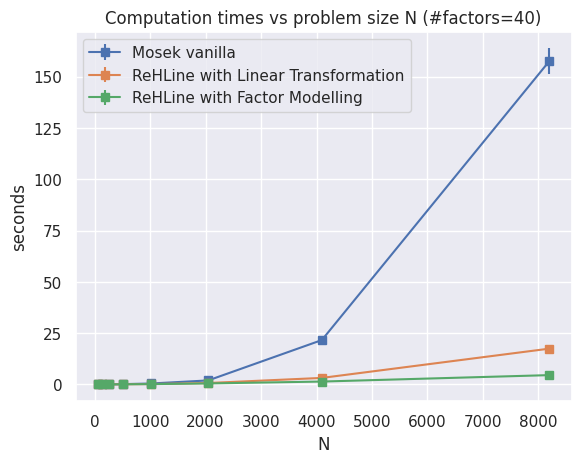

In [ ]:
plt.errorbar(Ns, mean_exec_times_mosek, yerr=std_exec_times_mosek, label="Mosek vanilla", marker='s')
plt.errorbar(Ns, mean_exec_times_reh_lt, yerr=std_exec_times_reh_lt, label="ReHLine with Linear Transformation", marker='s')
plt.errorbar(Ns, mean_exec_times_reh_fm, yerr=std_exec_times_reh_fm, label="ReHLine with Factor Modelling", marker='s')
plt.xlabel("N")
plt.ylabel("seconds")
plt.title(f"Computation times vs problem size N (#factors={n_factors})")
plt.legend()
plt.show()

## 2. Real data

In [65]:
# parameters
n_samples, n_assets, n_factors = len(beta_dict), beta_dict[0].shape[0], beta_dict[0].shape[1]
buy_cost, sell_cost = mu_df.std(axis=1).values*0.01, mu_df.std(axis=1).values*0.02
lb, ub = -1.0, +1.0
Psi = pd.DataFrame(mu_dict).var(axis=1).values

tol = 1e-4
max_iter = 1000
risk_aversion = 2.0
verbose = 0
trace_freq = 10

from rehline_po import FactorModel


def run_reh_fm(mu, beta, Psi, lam):
    A = np.r_[
        np.c_[np.ones(n_assets), np.ones(n_assets)*-1.0].T, 
        np.eye(n_assets),
        -np.eye(n_assets)]
    b = np.r_[-1.0, 1.0, -np.ones(n_assets)*lb, np.ones(n_assets)*ub]
    cov_fm = FactorModel(beta, Psi + lam*np.ones(n_assets), np.eye(n_factors))
    pf1 = MeanVariance(mu=mu, cov=cov_fm, A=A, b=b, buy_cost=buy_cost, sell_cost=sell_cost)
    weights_fm = pf1.max_quad_util_portf(tol=tol, risk_aversion=risk_aversion, 
                        max_iter=max_iter, verbose=verbose, trace_freq=trace_freq)
    return weights_fm, pf1._optimizer.n_iter_


def run_reh_lt(mu, beta, Psi, lam):
    cov = beta @ beta.T + np.diag(Psi) + lam*np.eye(n_assets)
    weights_reh_vanilla, _optimizer = max_quad_util_portf_rehline(n_assets, mu, cov, risk_aversion, 
                                                      buy_cost, sell_cost, lb, ub, 
                                                      max_iter, tol, verbose, trace_freq)
    return weights_reh_vanilla, _optimizer.n_iter_


def run_mosek(mu, beta, Psi, lam):
    cov = beta @ beta.T + np.diag(Psi) + lam*np.eye(n_assets)
    weights_mosek = max_quad_util_portf_mosek(n_assets, mu, cov, risk_aversion, 
                                                buy_cost, sell_cost, lb, ub, 
                                                tol, debug=False)
    return weights_mosek


def run_gurobi(mu, beta, Psi, lam):
    weights_gurobi = max_quad_util_portf_gurobi_fm(mu, beta, Psi + lam*np.eye(n_assets), 
                                                   risk_aversion, buy_cost, sell_cost, 
                                                   lb, ub)
    return weights_gurobi

In [112]:
exec_times_reh_fm, exec_times_reh_lt = [], []
exec_times_mosek, exec_times_gurobi = [], []
lam = 0.0
n_samples = 10
for i in tqdm(range(n_samples)):
    mu, beta = np.array(mu_dict[i]), np.array(beta_dict[i])
    
    start = time.time()
    run_reh_lt(mu, beta, Psi, lam)
    end = time.time()
    exec_times_reh_lt.append(end - start)

    start = time.time()
    run_reh_fm(mu, beta, Psi, lam)
    end = time.time()
    exec_times_reh_fm.append(end - start)
    
    start = time.time()
    run_mosek(mu, beta, Psi, lam)
    end = time.time()
    exec_times_mosek.append(end - start)

    start = time.time()
    run_gurobi(mu, beta, Psi, lam)
    end = time.time()
    exec_times_gurobi.append(end - start)


  0%|                                                    | 0/10 [00:00<?, ?it/s]

ValueError: operands could not be broadcast together with shapes (5058,5058) (8192,8192) 

In [176]:
data = pd.DataFrame({
    "method": ["ReH-FactorModel"]*n_samples+["ReH-LinearTrans"]*n_samples+["Mosek"]*n_samples,
    "exec_time": exec_times_reh_fm+exec_times_reh_lt+exec_times_mosek,
})

sns.boxplot(data, x="method", y="exec_time")
plt.title("Execution times on real data")
plt.show()

ValueError: All arrays must be of the same length

# Strong convexity & running time

As you could see, the results may seem not so promising: ReHLine based models,
albeit a little faster than generic convex solvers, still work on the order of 10s of seconds,
even when using factor analysis for boosting computation. However, in the original ReHLine
paper the proposed method clearly outperforms competing optimizers. So where's the problem?

The difference here lies in the data: it is well known that CD based methods work
slowly when the "degree of convexity" is low. As such, one might check that the smallest eigenvalue
of the covariance matrix $G = L \Sigma_f L^T + \Psi$ is quite low (order of $10^{-4}$). This leads to an
extremely slow performance. There is an argument that a portfolio with low eigenvalue is
overfitting to the data anyways and shouldn't be used in optimization without proper preprocessing.
Thus, let's see how with regularized $G$ the ReHLine based PO becomes faster. 

For this experiment, let's take the covariance matrix $G$ by shrinking its coefficients like
$$G = (L L^T + \Psi) + \lambda I_N$$
where $\lambda$ is the shrinking parameter. 

In [66]:
lams = np.logspace(-7, -1, 10)
i = 0

exec_times_reh_fm, exec_times_reh_lt, exec_times_mosek = [], [], []
n_iters_fm, n_iters_lt = [], []
for lam in tqdm(lams):
    mu, beta = np.array(mu_dict[i]), np.array(beta_dict[i])
    cov = beta @ beta.T + Psi + lam*np.eye(n_assets)
    
    start = time.time()
    w1, n_iter = run_reh_lt(mu, beta, Psi, lam)
    end = time.time()
    exec_times_reh_lt.append(end - start)
    n_iters_lt.append(n_iter)

    start = time.time()
    w2, n_iter = run_reh_fm(mu, beta, Psi, lam)
    end = time.time()
    exec_times_reh_fm.append(end - start)
    n_iters_fm.append(n_iter)
    
    start = time.time()
    run_mosek(mu, beta, Psi, lam)
    end = time.time()
    exec_times_mosek.append(end - start)

    print("l2_dist(reh_lt, reh_fm):", LA.norm(w1 - w2))

  0%|                                                    | 0/10 [00:00<?, ?it/s]

 10%|████▍                                       | 1/10 [01:22<12:25, 82.84s/it]

l2_dist(reh_lt, reh_fm): 0.0018922533551557945


 20%|████████▊                                   | 2/10 [02:41<10:42, 80.28s/it]

l2_dist(reh_lt, reh_fm): 0.0012539957795032607


 30%|█████████████▏                              | 3/10 [04:02<09:23, 80.55s/it]

l2_dist(reh_lt, reh_fm): 0.001594667929064771


 40%|█████████████████▌                          | 4/10 [05:26<08:11, 81.94s/it]

l2_dist(reh_lt, reh_fm): 0.0014037644283874178


 50%|██████████████████████                      | 5/10 [06:46<06:45, 81.15s/it]

l2_dist(reh_lt, reh_fm): 0.0017099404270956927


 60%|██████████████████████████▍                 | 6/10 [08:01<05:16, 79.22s/it]

l2_dist(reh_lt, reh_fm): 0.0010613406849558265


 70%|██████████████████████████████▊             | 7/10 [09:16<03:53, 77.87s/it]

l2_dist(reh_lt, reh_fm): 0.0008328526579486992


 80%|███████████████████████████████████▏        | 8/10 [10:16<02:24, 72.12s/it]

l2_dist(reh_lt, reh_fm): 0.0006216274214178106


 90%|███████████████████████████████████████▌    | 9/10 [11:09<01:06, 66.28s/it]

l2_dist(reh_lt, reh_fm): 2.4764082184557566e-05


100%|███████████████████████████████████████████| 10/10 [12:03<00:00, 72.39s/it]

l2_dist(reh_lt, reh_fm): 1.1327299454197273e-06


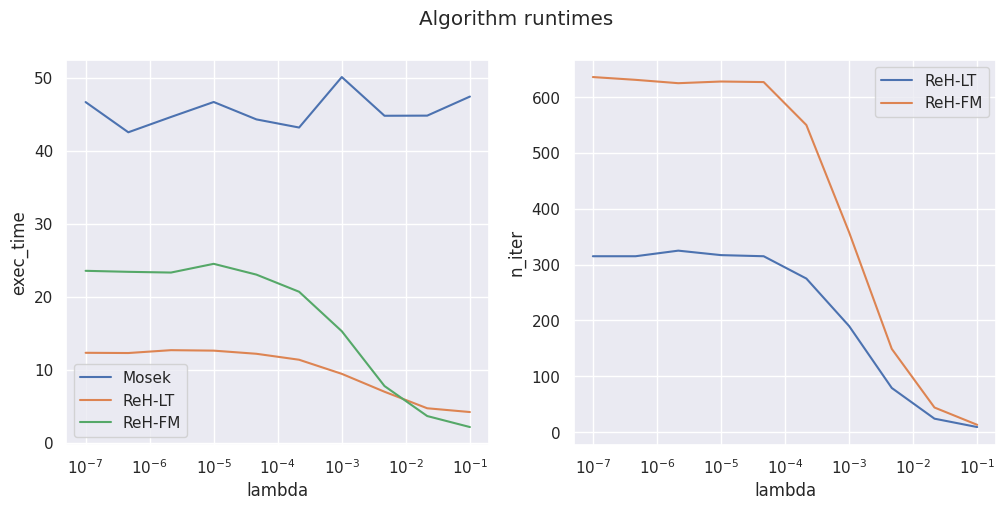

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(lams, exec_times_mosek, label="Mosek")
ax[0].plot(lams, exec_times_reh_lt, label="ReH-LT")
ax[0].plot(lams, exec_times_reh_fm, label="ReH-FM")
ax[0].set_xlabel("lambda")
ax[0].set_ylabel("exec_time")
ax[0].set_xscale('log')
ax[0].legend()

ax[1].plot(lams, n_iters_lt, label="ReH-LT")
ax[1].plot(lams, n_iters_fm, label="ReH-FM")
ax[1].set_xlabel("lambda")
ax[1].set_ylabel("n_iter")
ax[1].set_xscale('log')
ax[1].legend()

fig.suptitle("Algorithm runtimes")
plt.show()

In [38]:
# runtime details
import cProfile

i = 0
mu, beta = np.array(mu_dict[i]), np.array(beta_dict[i])
lam = 0.01


cProfile.runctx("run_reh_fm(mu, beta, Psi, lam)", {
    "run_reh_fm": run_reh_fm,
    "mu": mu,
    "beta": beta,
    "Psi": Psi, 
    "lam": lam,
}, {})

cProfile.runctx("run_reh_lt(mu, beta, Psi, lam)", {
    "run_reh_lt": run_reh_lt,
    "mu": mu,
    "beta": beta,
    "Psi": Psi, 
    "lam": lam,
}, {})

cProfile.runctx("run_mosek(mu, beta, Psi, lam)", {
    "run_mosek": run_mosek,
    "mu": mu,
    "beta": beta,
    "Psi": Psi, 
    "lam": lam,
}, {})

         1184695 function calls (1184687 primitive calls) in 5.709 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.340    0.340    5.168    5.168 2363401345.py:16(run_reh_fm)
        4    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1390(_handle_fromlist)
        1    0.001    0.001    5.168    5.168 <string>:1(<module>)
     5058    0.003    0.000    0.004    0.000 PLQLoss.py:222(merge_successive_intervals)
     5058    0.078    0.000    0.086    0.000 PLQLoss.py:68(__init__)
     5058    0.034    0.000    0.117    0.000 PLQProperty.py:12(is_continuous)
     5058    0.018    0.000    0.035    0.000 PLQProperty.py:126(find_min)
     5058    0.157    0.000    0.573    0.000 PLQProperty.py:153(plq_to_rehloss)
     5058    0.016    0.000    0.053    0.000 PLQProperty.py:51(is_convex)
     5058    0.006    0.000    0.010    0.000 PLQProperty.py:87(check_cutoff)
        1    0.000    0.000    0.0

How about for the synthetic data? How does the results look like there?

In [79]:
lams = np.logspace(-5, 0, 10)

n_samples = 5
n_assets, n_factors = 5000, 40
buy_cost, sell_cost = 0.01*np.ones(n_assets), 0.02*np.ones(n_assets)
lb, ub = -1.0, +1.0

exec_times_reh_fm, exec_times_reh_lt, exec_times_gurobi = [], [], []
n_iters_fm, n_iters_lt = [], []
for lam in tqdm(lams):
    et_fm, et_lt, et_gurobi = [], [], []
    ni_fm, ni_lt = [], [] 
    for i in range(n_samples):
        L = np.random.uniform(size=(n_assets, n_factors))
        Psi = lam * np.ones(n_assets)
        mu = random_mu(n_assets)
        cov = L @ L.T + Psi

        start = time.time()
        _, n_iter = run_reh_lt(mu, L, Psi, lam=0.0)
        end = time.time()
        et_lt.append(end - start)
        ni_lt.append(n_iter)

        start = time.time()
        _, n_iter = run_reh_fm(mu, L, Psi, lam=0.0)
        end = time.time()
        et_fm.append(end - start)
        ni_fm.append(n_iter)

        start = time.time()
        _ = max_quad_util_portf_gurobi_fm(mu, beta, Psi, risk_aversion, buy_cost, sell_cost, lb, ub)
        end = time.time()
        et_gurobi.append(end - start)
        
    exec_times_reh_fm.append(np.mean(et_fm))
    exec_times_reh_lt.append(np.mean(et_lt))
    exec_times_gurobi.append(np.mean(et_gurobi))
    n_iters_fm.append(np.mean(ni_fm))
    n_iters_lt.append(np.mean(ni_lt))


100%|██████████████████████████████████████████| 10/10 [50:34<00:00, 303.43s/it]


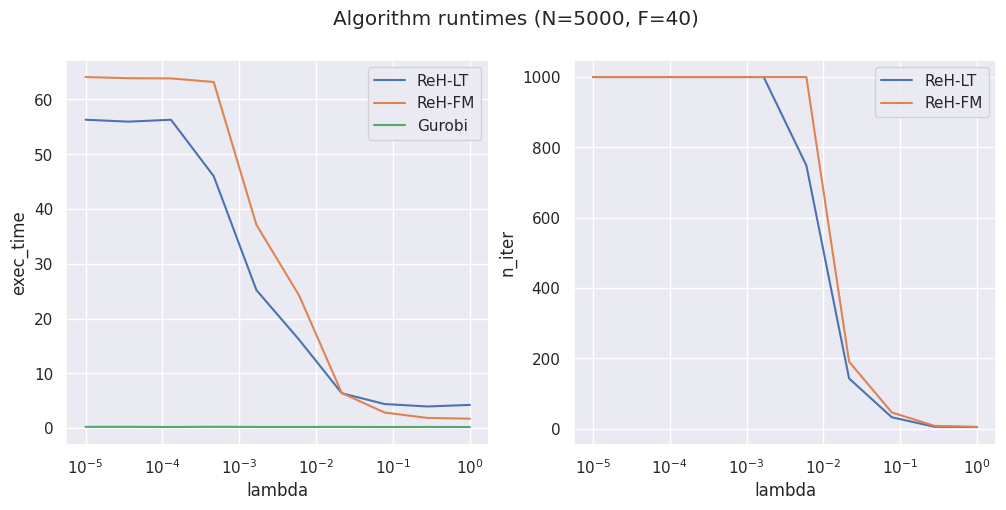

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(lams, exec_times_reh_lt, label="ReH-LT")
ax[0].plot(lams, exec_times_reh_fm, label="ReH-FM")
ax[0].plot(lams, exec_times_gurobi, label="Gurobi")
ax[0].set_xlabel("lambda")
ax[0].set_ylabel("exec_time")
ax[0].set_xscale('log')
ax[0].legend()

ax[1].plot(lams, n_iters_lt, label="ReH-LT")
ax[1].plot(lams, n_iters_fm, label="ReH-FM")
ax[1].set_xlabel("lambda")
ax[1].set_ylabel("n_iter")
ax[1].set_xscale('log')
ax[1].legend()

fig.suptitle(f"Algorithm runtimes (N={n_assets}, F={n_factors})")
plt.show()

# More complex transaction cost functions
Now let's compare Gurobi with ReHLine based PO when a more complicated version 
of transaction cost function $\phi_i$ is given (i.e. more #linear pieces). For details of $\phi_i$
see `utils.py` and `MeanVariance.ipynb`.

In [6]:
from rehline_po import FactorModel, MeanVariance

n_samples, n_assets, n_factors = 5, beta_dict[0].shape[0], beta_dict[0].shape[1]

V = 1.0
vp, vm = 0.01*mu_df.std(axis=1), 0.02*mu_df.std(axis=1)
d_vp, d_vm = vp*0.1, vm*0.15

lb, ub = -1.0, +1.0
risk_aversion = 2.0
Psi = pd.DataFrame(mu_dict).var(axis=1).values
lam = 0.01
aug_Psi = Psi + lam*np.ones(n_assets)

tol = 1e-4
max_iter = 1000
verbose = 0
trace_freq = 10

def run_wrapper(args):
    return run(*args)

def run(L, method, sample_idx):
    mu, beta = mu_dict[sample_idx], beta_dict[sample_idx]
    transaction_costs = create_plqloss_from_volume(V, L, vp, vm, d_vp, d_vm)
    if method == "reh_lt":
        start = time.time()
        cov = beta @ beta.T + np.diag(aug_Psi)
        weights, _optimizer = max_quad_util_portf_rehline_plq(len(mu), mu, cov, 
                                                    transaction_costs, risk_aversion, lb, ub)
        end = time.time()
        return weights, end-start, method, L
    elif method == "reh_fm":
        start = time.time()
        A = np.r_[
            np.c_[np.ones(n_assets), np.ones(n_assets)*-1.0].T, 
            np.eye(n_assets),
            -np.eye(n_assets)]
        b = np.r_[-1.0, 1.0, -np.ones(n_assets)*lb, np.ones(n_assets)*ub]
        cov_fm = FactorModel(beta, aug_Psi , np.eye(n_factors))
        pf1 = MeanVariance(mu=mu, cov=cov_fm, A=A, b=b, transaction_costs=transaction_costs)
        weights = pf1.max_quad_util_portf(tol=tol, risk_aversion=risk_aversion, 
                            max_iter=max_iter, verbose=verbose, trace_freq=trace_freq)
        end = time.time()
        return weights, end-start, method, L
    elif method == "gurobi":
        start = time.time()
        weights = max_quad_util_portf_gurobi_fm_plq(mu, beta, aug_Psi, risk_aversion, 
                                          transaction_costs, lb, ub)
        end = time.time()
        return weights, end-start, method, L
    else:
        raise ValueError(f"`method` argument {method} doesn't exist")


Ls = [1, 10, 30]
methods = ["reh_lt", "reh_fm", "gurobi"]
sample_inds = list(range(n_samples))

from itertools import product
from tqdm.contrib.concurrent import process_map  # or thread_map

# set n_workers to speed-up the process will change optmizer runtimes due to race conditions
n_workers = 1
results = process_map(run_wrapper, product(Ls, methods, sample_inds), max_workers=n_workers)

print(len(results))

/home/alibek/ReHLine-PO/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
0it [00:00, ?it/s]

45it [12:00, 16.02s/it]

45


In [7]:
stripped_results = [tpl[1:] for tpl in results]
data = pd.DataFrame(stripped_results, columns=["elapsed_time", "method", "L"])    
data.head()

,elapsed_time,method,L
0,11.313364,reh_lt,1
1,12.494355,reh_lt,1
2,14.230943,reh_lt,1
3,15.234449,reh_lt,1
4,5.741525,reh_lt,1


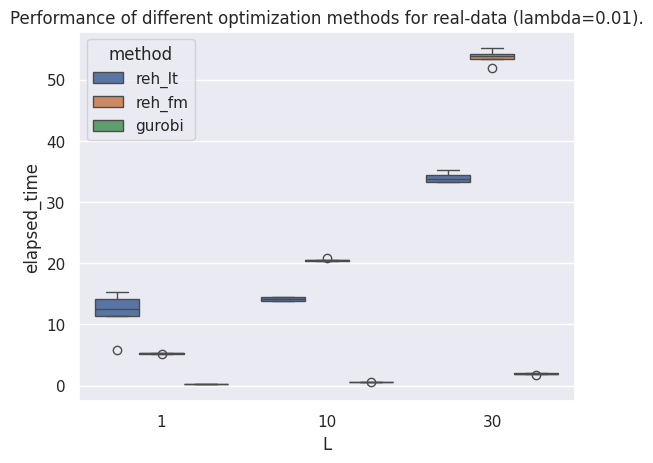

In [8]:
sns.boxplot(data, x="L", y="elapsed_time", hue="method")
plt.title(f"Performance of different optimization methods for real-data (lambda={lam}).")
plt.show()

In [10]:
n_samples, n_assets, n_factors = 1, beta_dict[0].shape[0], beta_dict[0].shape[1]

V = 1.0
vp, vm = 0.01*mu_df.std(axis=1), 0.02*mu_df.std(axis=1)
d_vp, d_vm = vp*0.1, vm*0.15

lb, ub = -1.0, +1.0
risk_aversion = 2.0
Psi = pd.DataFrame(mu_dict).var(axis=1).values

tol = 1e-4
max_iter = 1000
verbose = 0
trace_freq = 10

lams = np.logspace(-4, 0, 10)
Ls = [1, 10, 30]
results = []
sample_inds = np.random.choice(len(beta_dict), n_samples)

for lam, L, method, i in tqdm(product(lams, Ls, methods, sample_inds)):
    aug_Psi = Psi + lam*np.ones(n_assets)
    _weights, elapsed_time, method, L = run(L, method, i)
    results.append((lam, L, method, i, elapsed_time))

len(results)

90it [33:30, 22.34s/it]


90

In [11]:
data = pd.DataFrame(results, columns=["lam", "L", "method", "sample_idx", "elapsed_time"])
data.head()

,lam,L,method,sample_idx,elapsed_time
0,0.0001,1,reh_lt,15,11.995773
1,0.0001,1,reh_fm,15,22.390688
2,0.0001,1,gurobi,15,0.212695
3,0.0001,10,reh_lt,15,42.637002
4,0.0001,10,reh_fm,15,76.237405


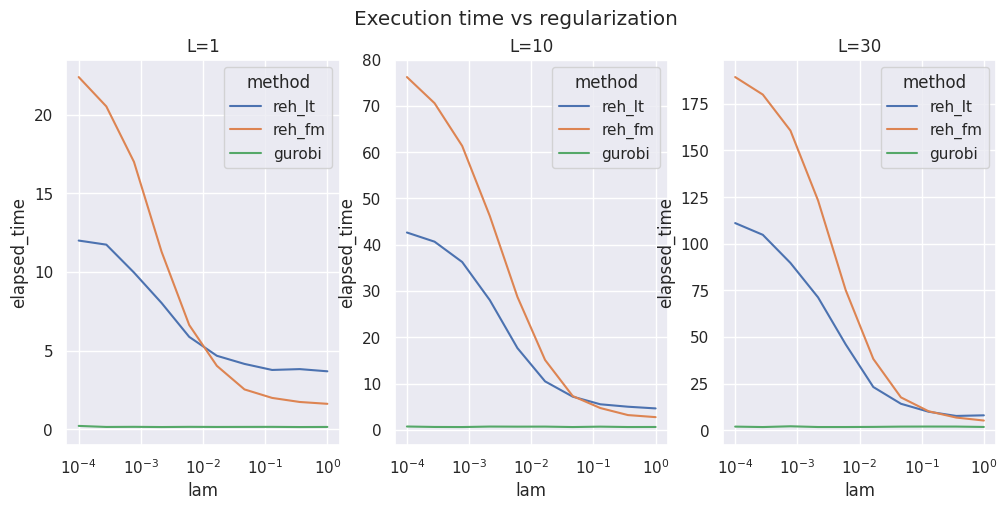

In [14]:
fig, ax = plt.subplots(1, len(Ls), figsize=(12, 5))

for i, L in enumerate(Ls):
    sns.lineplot(data[data.L == L], x="lam", y="elapsed_time", hue="method", ax=ax[i])
    ax[i].set_xscale("log")
    ax[i].set_title(f"L={L}")

fig.suptitle("Execution time vs regularization")
plt.show()